# 4 Detailed Preprocessing of Passive Data

This notebook shows the analysis of situational context using EMA and passive sensing data

1. **Load Data**: Load necessary data from pickle files.
2. **Preprocess EMA**:

In [1]:
import os
import sys
import regex as re
from tqdm import tqdm
from intervaltree import IntervalTree

%load_ext autoreload
%autoreload 2
import logging
# Configure logging
logging.basicConfig(level=logging.INFO)

# If your current working directory is the notebooks directory, use this:
notebook_dir = os.getcwd()  # current working directory
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
import glob
import pickle
from IPython.display import Markdown
from server_config import datapath, preprocessed_path

import pandas as pd
import numpy as np
import datetime as dt
import EMA_Mapper
import gps_features

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from math import radians, cos, sin, asin, sqrt
import statistics  # Make sure this is imported
import hdbscan

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import matplotlib.patches as mpatches
# Ensure matplotlib displays plots inline (if using Jupyter Notebook)
%matplotlib inline

sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set(style='whitegrid', context='talk', palette='deep')
%matplotlib inline
import plotly.express as px


In [2]:
backup_path = preprocessed_path + "/backup_data_passive_actual.feather"
df_backup = pd.read_feather(backup_path)

with open(preprocessed_path + '/ema_data.pkl', 'rb') as file:
    df_ema_framework = pickle.load(file)

with open(preprocessed_path + '/ema_content.pkl', 'rb') as file:
    df_ema_content = pickle.load(file)  

with open(preprocessed_path + '/monitoring_data.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

In [3]:
# Configurations
# Check min. amount of EMA data available to map to passive data

#GPS data
speed_limit = 1.4
max_distance = 150 
kms_per_radian = 6371000
epsilon = 100/kms_per_radian
min_samples = 10
min_cluster_size = 20
min_nights_obs = 4
min_f_home = 0.5

# EMA
assessment_phase = [0] #1,2
min_num_daily = 4
min_days_data = 7


#Passive to EMA matching
timedelta_hours = 2
assess = 0

### Data overview

## Filter for participants with sufficient data

In [4]:
df_ema1 = df_ema_content.loc[df_ema_content.study.isin([24,25])] # first assessment phase
df_ema1 = df_ema1.loc[df_ema1["n_quest"] >= min_num_daily]
df_ema1["n_days_min"] = df_ema1.groupby("customer")['quest_complete_day'].transform("nunique")
df_ema1 = df_ema1.loc[df_ema1.n_days_min >= min_days_data]
df_ema1_customers = df_ema1.customer.unique().tolist()


In [5]:
df_ema1.customer.nunique()

203

### Analyze missingness

In [6]:
# List of customers
customers = df_ema1['customer'].unique()

# List of days (assuming absolute_day_index starts from 1)
days = range(1, df_ema1['absolute_day_index'].max() + 1)

# List of expected quest numbers per day (e.g., quest_nr from 1 to 8)
expected_quests = [1, 2, 3, 4, 5, 6, 7, 8]  # Adjust based on your actual quest numbers

# Create a MultiIndex of all combinations
index = pd.MultiIndex.from_product([customers, days, expected_quests], names=['customer', 'absolute_day_index', 'quest_nr'])

# Create a DataFrame representing the complete schedule
df_expected = pd.DataFrame(index=index).reset_index()

In [7]:
# Select relevant columns from completed quests
df_completed = df_ema1[['customer', 'absolute_day_index', 'quest_nr']].drop_duplicates()

# Merge expected and completed quests
df_quests = pd.merge(df_expected, df_completed, on=['customer', 'absolute_day_index', 'quest_nr'], how='left', indicator=True)

# '_merge' column will indicate if the quest was completed ('both') or missing ('left_only')
df_quests['quest_status'] = np.where(df_quests['_merge'] == 'both', 'Completed', 'Missing')
df_quests.drop(columns=['_merge'], inplace=True)


In [8]:
# Extract the hour from 'quest_create'
df_ema_content['quest_create_hour'] = df_ema_content['quest_create'].dt.hour

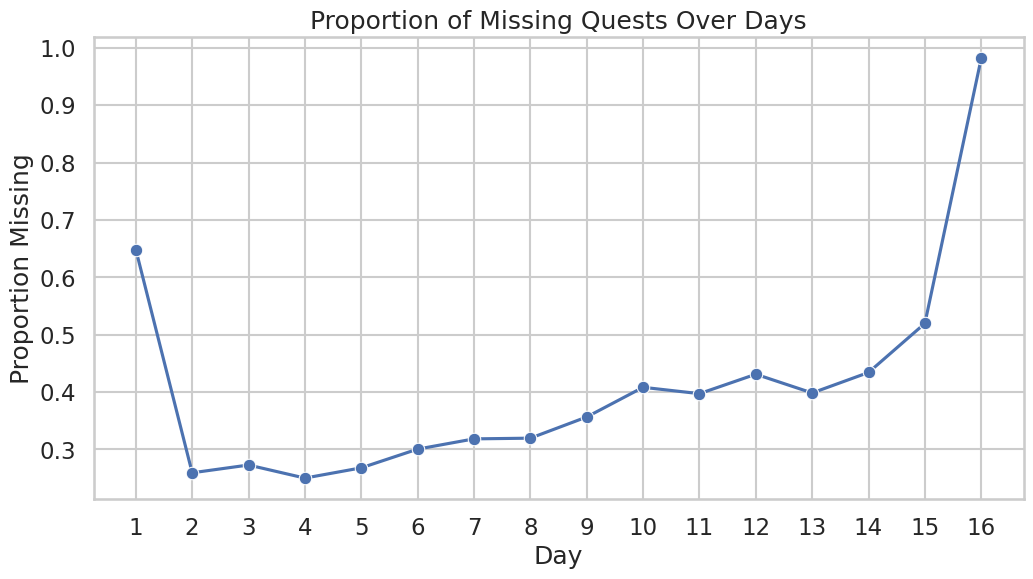

In [9]:
# Calculate the proportion of missing quests per day
missingness_by_day = df_quests.groupby('absolute_day_index')['quest_status'].apply(lambda x: (x == 'Missing').mean()).reset_index()

# Plotting missingness over days
plt.figure(figsize=(12, 6))
sns.lineplot(x='absolute_day_index', y='quest_status', data=missingness_by_day, marker='o')
plt.title('Proportion of Missing Quests Over Days')
plt.xlabel('Day')
plt.ylabel('Proportion Missing')
plt.xticks(range(1, df_quests['absolute_day_index'].max() + 1))
plt.grid(True)
plt.show()


## 1. Prepare passive features

In [10]:
df_pass_act = df_backup.copy()

In [11]:
df_pass_act.startTimestamp.max()

Timestamp('2024-12-09 01:19:30.060000')

In [12]:
# Only keep data that were collected during the first assessment phase
df_pass_act_base = df_pass_act[df_pass_act.startTimestamp <= (df_pass_act.ema_base_end + pd.Timedelta(days=1))]

In [13]:
df_pass_act_base = df_pass_act_base.loc[df_pass_act_base.customer.isin(df_ema1_customers)]

In [37]:
df_pass_act_base.customer.nunique()

202

In [15]:
df_pass_act_base['Heart_Rate_data_coverage_per'].replace([np.inf, -np.inf], np.nan, inplace=True)


/tmp/ipykernel_3520499/2028720565.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pass_act_base['Heart_Rate_data_coverage_per'].replace([np.inf, -np.inf], np.nan, inplace=True)


### 1.1 Calculate GPS features

In [16]:
df_pass_act_loc =df_pass_act_base[df_pass_act_base.type.isin(["Latitude", "Longitude"])][["customer", "startTimestamp", "type", "doubleValue"]]

In [17]:
df_loc = df_pass_act_loc.pivot_table(
    index=["customer", "startTimestamp"],
    columns="type",
    values=["doubleValue"],
    aggfunc='first'  # Using 'first' since each type should theoretically have only one entry per customer and timestamp
)

# Flatten the MultiIndex in columns
df_loc.columns = ['_'.join(col).strip() for col in df_loc.columns.values]

df_loc = df_loc.rename_axis(None, axis=1).reset_index()

# Rename the columns for clarity
df_loc = df_loc.rename(columns={
    'doubleValue_Latitude': 'Latitude',
    'doubleValue_Longitude': 'Longitude',
})

In [39]:
# Example usage with HDBSCAN and normalized min_samples:
extractor = gps_features.HomeClusterExtractor(df_loc, speed_limit=speed_limit, max_distance=max_distance, epsilon=epsilon, min_samples=min_samples, 
                                 min_nights_obs = min_nights_obs, min_f_home=min_f_home, clustering_method='dbscan', 
                                 normalize_min_samples=False, min_data_points=56)
result = extractor.run()


INFO:root:Data quality check: 183 customers with sufficient data retained.
INFO:root:Customers with no home after time-based method: 22
INFO:root:Fallback home clusters assigned: 22


In [19]:
# 18 customers not enough GPS data (i.e. less than 50 data points, so that no home cluster could be computed 


In [20]:
home_clusters_red = result[["customer", "startTimestamp", "at_home","transition", "distance", "stationary","time_diff", "speed", "clusterID", "homeID" ]]

In [21]:
result.transition.unique()

array([0, 1])

In [22]:
gps_customer_list = home_clusters_red.customer.unique().tolist()

In [23]:
df_pass_act_base.loc[df_pass_act_base.type =="ActivityType"]

,customer,type,startTimestamp,endTimestamp,doubleValue,longValue,booleanValue,dateValue,stringValue,userReliability,...,Heart_Rate_actual_days_with_data,Heart_Rate_data_coverage_per,ema_relative_start_phase0,ema_relative_end_phase0,ema_relative_start_phase1,ema_relative_end_phase1,ema_relative_start_phase2,ema_relative_end_phase2,for_id,ema_id
72,4MLe,ActivityType,2023-05-17 20:39:00.000,2023-05-17 20:47:00.000,NaN,105.0,False,NaN,-99,NaN,...,343.0,72.362869,NaT,NaT,NaT,NaT,NaT,NaT,None,None
138,4MLe,ActivityType,2023-05-17 21:00:00.000,2023-05-17 21:07:00.000,NaN,105.0,False,NaN,-99,NaN,...,343.0,72.362869,NaT,NaT,NaT,NaT,NaT,NaT,None,None
163,4MLe,ActivityType,2023-05-17 21:19:00.000,2023-05-17 21:27:00.000,NaN,105.0,False,NaN,-99,NaN,...,343.0,72.362869,NaT,NaT,NaT,NaT,NaT,NaT,None,None
198,4MLe,ActivityType,2023-05-17 21:33:00.000,2023-05-17 21:59:00.000,NaN,105.0,False,NaN,-99,NaN,...,343.0,72.362869,NaT,NaT,NaT,NaT,NaT,NaT,None,None
414,4MLe,ActivityType,2023-05-18 00:38:00.000,2023-05-18 00:40:00.000,NaN,103.0,False,NaN,-99,NaN,...,343.0,72.362869,NaT,NaT,NaT,NaT,NaT,NaT,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65230631,nbKT,ActivityType,2024-12-07 07:08:00.060,2024-12-07 07:14:00.060,NaN,102.0,False,NaN,-99,NaN,...,6.0,75.000000,2024-11-27,2024-12-08,NaT,NaT,NaT,NaT,FOR13088,EMA3144
65230637,nbKT,ActivityType,2024-12-07 07:14:00.060,2024-12-07 07:19:00.060,NaN,102.0,False,NaN,-99,NaN,...,6.0,75.000000,2024-11-27,2024-12-08,NaT,NaT,NaT,NaT,FOR13088,EMA3144
65230778,nbKT,ActivityType,2024-12-07 11:20:00.060,2024-12-07 12:00:00.060,NaN,105.0,False,NaN,-99,NaN,...,6.0,75.000000,2024-11-27,2024-12-08,NaT,NaT,NaT,NaT,FOR13088,EMA3144
65230963,nbKT,ActivityType,2024-12-07 12:46:00.060,2024-12-07 12:52:00.060,NaN,105.0,False,NaN,-99,NaN,...,6.0,75.000000,2024-11-27,2024-12-08,NaT,NaT,NaT,NaT,FOR13088,EMA3144


In [24]:
df_pass_act_base['type'].value_counts()


type
Longitude                      897261
Latitude                       897260
CoveredDistance                571958
Steps                          571958
HeartRate                      564971
ActiveBurnedCalories           562057
RawECGVoltage                  133444
ActivityType                    66797
SleepInBedBinary                36067
SleepStateBinary                32887
SleepBinary                     32887
SleepLightBinary                30380
SleepDeepBinary                 24546
ElevationGain                    9732
SleepAwakeBinary                 8705
ActivityTypeDetail1              7739
ActivityTypeDetail2              7733
WalkBinary                       6313
FloorsClimbed                    6179
SPO2                             5580
AtrialFibrillationDetection      1360
BikeBinary                       1149
ActiveBinary                      344
RunBinary                         104
Weight                             64
FatMass                            22
FatFree

## 2. Prepare EMA data

In [25]:
df_ema_udi = df_ema_content[["customer", "createdAt_day", "quest_create", "unique_day_id", "assess"]]

In [26]:
# Group by customer and unique_day_id and calculate the minimum quest_create
df_min_quest = df_ema_udi.groupby(['customer', 'unique_day_id'])['quest_create'].min().reset_index()

# Rename the column to sensor_block_end
df_min_quest.rename(columns={'quest_create': 'sensor_block_end'}, inplace=True)

# Merge the minimum quest_create back to the original DataFrame
df_ema_udi = pd.merge(df_ema_udi, df_min_quest, on=['customer', 'unique_day_id'], how='left')

# Create the sensor_block_start column, which is 2 hours before quest_create
df_ema_udi.drop(columns=['quest_create'], inplace=True)
df_ema_udi = df_ema_udi.drop_duplicates()

In [27]:
# prepare mapping of passing data by creating blocks

df_ema_udi['sensor_block_start'] = df_ema_udi['sensor_block_end'] - pd.Timedelta(hours=2)


In [28]:
# Only include first assessment phase

df_ema_udi_base = df_ema_udi.loc[df_ema_udi.assess == 0]

In [29]:
df_ema_udi_base.shape

(19377, 6)

In [30]:
df_ema_udi_base = df_ema_udi_base.copy()
df_ema_udi_base["unique_blocks"] = df_ema_udi_base.customer + df_ema_udi_base.unique_day_id

## 3. Merge EMA to passive data

In [31]:
# Step 1: Initialize the EMAMapper
ema_mapper = EMA_Mapper.EMAMapper(df_ema_udi_base, df_pass_act_base, home_clusters_red)

# Step 2: Run the mappings
ema_mapper.run_mappings()

# Step 3: Retrieve the enriched EMA DataFrame
df_ema_enriched = ema_mapper.get_result()

Heart Rate Data Cleaning Summary:
Initial entries: 564971
Removed due to non-numeric values: 0
Removed due to thresholds: 0
Removed due to exceeding change rate threshold: 5745
Total entries removed: 5745
Remaining entries: 559226
Step Data Cleaning Summary:
Initial entries: 571958
Removed due to non-numeric values: 0
Removed due to negative steps: 0
Removed due to zero or negative duration: 0
Removed due to exceeding steps per minute threshold: 374
Total entries removed: 374
Remaining entries: 571584


/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0
/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0
/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

ActiveBurnedCalories Data Cleaning Summary:
Initial entries: 562057
Remaining entries: 562057
Entries removed: 0


/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0
/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0
/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

CoveredDistance Data Cleaning Summary:
Initial entries: 571958
Remaining entries: 571958
Entries removed: 0


/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0
/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0
/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Available columns in df_data: ['customer', 'type', 'startTimestamp', 'endTimestamp', 'doubleValue', 'longValue', 'booleanValue', 'dateValue', 'stringValue', 'userReliability', 'chronologicalExactness', 'timezoneOffset', 'starttimestamp', 'endtimestamp', 'startTimestamp_day', 'startTimestamp_hour', 'start_end', 'status', 'study_version', 'ema_base_start', 'ema_base_end', 'potential_days_coverage', 'GPS_actual_days_with_data', 'GPS_data_coverage_per', 'Activity_actual_days_with_data', 'Activity_data_coverage_per', 'Sleep_actual_days_with_data', 'Sleep_data_coverage_per', 'Heart_Rate_actual_days_with_data', 'Heart_Rate_data_coverage_per', 'ema_relative_start_phase0', 'ema_relative_end_phase0', 'ema_relative_start_phase1', 'ema_relative_end_phase1', 'ema_relative_start_phase2', 'ema_relative_end_phase2', 'for_id', 'ema_id']
Available types in 'type' column: <StringArray>
[                      'Steps',        'ActiveBurnedCalories',
             'CoveredDistance',                   'HeartR

/home/leha18/tiki_code/src/EMA_Mapper.py:684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0


Batch 1 joined shape: (1642314, 68)
Batch 1 after overlap filtering: (10730, 68)
Processing batch 2/4...


/home/leha18/tiki_code/src/EMA_Mapper.py:684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0


Batch 2 joined shape: (1227435, 68)
Batch 2 after overlap filtering: (4432, 68)
Processing batch 3/4...


/home/leha18/tiki_code/src/EMA_Mapper.py:684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0


Batch 3 joined shape: (1455911, 68)
Batch 3 after overlap filtering: (6129, 68)
Processing batch 4/4...


/home/leha18/tiki_code/src/EMA_Mapper.py:684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0


Batch 4 joined shape: (1137126, 68)
Batch 4 after overlap filtering: (4896, 68)
Before merging results with EMA DataFrame:
Index(['unique_blocks', 'activity_102_minutes', 'activity_103_minutes',
       'activity_104_minutes', 'activity_105_minutes', 'activity_106_minutes',
       'activity_107_minutes'],
      dtype='object')
Final EMA DataFrame shape after activity mapping: (19377, 37)


In [32]:
def summarize_missing_data(df, columns):
    """
    Summarizes the number of -1 values in the specified columns and calculates
    the number of blocks with complete data or missing data.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list): List of column names to check for -1 values.

    Returns:
        None: Prints the summary to the console.
    """
    print("Summary of Missing Data (-1 values):\n")
    
    # Absolute and percentage of -1 values per column
    total_rows = len(df)
    missing_summary = {
        "Column": [],
        "Missing (-1)": [],
        "Percentage (%)": []
    }
    
    for col in columns:
        if col in df.columns:
            missing_count = (df[col] == -1).sum()
            missing_summary["Column"].append(col)
            missing_summary["Missing (-1)"].append(missing_count)
            missing_summary["Percentage (%)"].append(round((missing_count / total_rows) * 100, 2))
    
    # Print the summary for each column
    for i in range(len(missing_summary["Column"])):
        print(f"{missing_summary['Column'][i]}: {missing_summary['Missing (-1)'][i]} "
              f"({missing_summary['Percentage (%)'][i]}%)")
    
    print("\nSummary of Blocks with Missing Data:\n")
    
    # Count the number of -1 values per block
    df["missing_count"] = (df[columns] == -1).sum(axis=1)
    
    # Count the number of blocks with complete data and varying levels of missing data
    complete_blocks = (df["missing_count"] == 0).sum()
    missing_counts = df["missing_count"].value_counts().sort_index()
    
    print(f"Complete blocks (no -1 values): {complete_blocks} "
          f"({round((complete_blocks / total_rows) * 100, 2)}%)")
    
    for num_missing, count in missing_counts.items():
        if num_missing > 0:
            print(f"Blocks with {num_missing} variable(s) missing: {count} "
                  f"({round((count / total_rows) * 100, 2)}%)")
    
    # Clean up temporary column
    df.drop(columns=["missing_count"], inplace=True)

In [33]:
df_ema_enriched.columns

Index(['customer', 'createdAt_day', 'unique_day_id', 'assess',
       'sensor_block_end', 'sensor_block_start', 'unique_blocks', 'hr_mean',
       'hr_min', 'hr_max', 'hr_std', 'hr_median', 'range_heartrate',
       'iqr_heartrate', 'skewness_heartrate', 'kurtosis_heartrate',
       'hr_peak_counts', 'hr_slope', 'hr_zone_resting', 'hr_zone_moderate',
       'hr_zone_vigorous', 'n_steps', 'total_activeburnedcalories',
       'total_covereddistance', 'n_GPS', 'total_distance_km', 'at_home_minute',
       'time_in_transition_minutes', 'time_stationary_minutes',
       'prop_time_moving', 'prop_time_stationary', 'activity_102_minutes',
       'activity_103_minutes', 'activity_104_minutes', 'activity_105_minutes',
       'activity_106_minutes', 'activity_107_minutes'],
      dtype='object')

In [34]:
columns_to_check = ['n_steps', 'hr_mean', 'hr_min', 'hr_max', 'hr_std', 'hr_median',
                    'range_heartrate', 'iqr_heartrate', 'skewness_heartrate',
                    'kurtosis_heartrate', 'hr_peak_counts', 'hr_slope', 'hr_zone_resting',
                    'hr_zone_moderate', 'hr_zone_vigorous', 'n_GPS', 'total_distance_km',
                    'at_home_minute', 'time_in_transition_minutes',
                    'time_stationary_minutes', 'prop_time_moving', 'prop_time_stationary', 'total_activeburnedcalories', 'total_covereddistance',
                   'activity_102_minutes','activity_103_minutes', 'activity_104_minutes', 'activity_105_minutes','activity_106_minutes', 'activity_107_minutes']

summarize_missing_data(df_ema_enriched, columns_to_check)


Summary of Missing Data (-1 values):

n_steps: 7189 (37.1%)
hr_mean: 0 (0.0%)
hr_min: 0 (0.0%)
hr_max: 0 (0.0%)
hr_std: 0 (0.0%)
hr_median: 0 (0.0%)
range_heartrate: 0 (0.0%)
iqr_heartrate: 0 (0.0%)
skewness_heartrate: 0 (0.0%)
kurtosis_heartrate: 0 (0.0%)
hr_peak_counts: 0 (0.0%)
hr_slope: 0 (0.0%)
hr_zone_resting: 123 (0.63%)
hr_zone_moderate: 123 (0.63%)
hr_zone_vigorous: 123 (0.63%)
n_GPS: 10606 (54.73%)
total_distance_km: 10606 (54.73%)
at_home_minute: 10967 (56.6%)
time_in_transition_minutes: 10606 (54.73%)
time_stationary_minutes: 10606 (54.73%)
prop_time_moving: 10606 (54.73%)
prop_time_stationary: 10606 (54.73%)
total_activeburnedcalories: 7424 (38.31%)
total_covereddistance: 7187 (37.09%)
activity_102_minutes: 11914 (61.49%)
activity_103_minutes: 11914 (61.49%)
activity_104_minutes: 11914 (61.49%)
activity_105_minutes: 11914 (61.49%)
activity_106_minutes: 11914 (61.49%)
activity_107_minutes: 11914 (61.49%)

Summary of Blocks with Missing Data:

Complete blocks (no -1 values):

In [35]:
# Select the relevant columns
columns_of_interest = [
    'n_steps', 'hr_mean', 'hr_min', 'hr_max', 'hr_std', 'hr_median', 'n_GPS'
     'total_distance_km', 'at_home_minute', 
    'time_in_transition_minutes', 'time_stationary_minutes', 'total_activeburnedcalories', 'total_covereddistance',

    
]

# Filter the DataFrame to these columns
correlation_data = df_ema_enriched[columns_of_interest]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Display the correlation matrix
print(correlation_matrix)

KeyError: "['n_GPStotal_distance_km'] not in index"

In [ ]:
# covered distance just combi of steps, height, weight..

In [ ]:
with open(preprocessed_path + '/map_ema_passive.pkl', 'wb') as file:
    pickle.dump(df_ema_with_at_home, file)